In [1]:
from logisticRegression import LogisticRegression, Optimizer
from scipy.io.arff import loadarff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle
from IPython.display import clear_output

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_21568\4102050876.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Helper functions

In [2]:
def addInteractions(X):
    newX=X
    for i in range(X.shape[1]):
        for j in range(i+1,X.shape[1]):
            newX=np.c_[newX,np.multiply(X[:,i],X[:,j])]
    return newX

In [3]:
def getMeanAccuracyPerSplit(accuracies):
    return accuracies.groupby(['split','classifier'])['accuracy'].mean().reset_index(name='accuracy')
def getMeanAccuracyPerDataset(accuracies):
    return accuracies.groupby(['dataset','classifier'])['accuracy'].mean().reset_index(name='accuracy')


In [4]:
def mapOptimizerToString(datapoint):
    match datapoint['classifier']:
        case Optimizer.Adam:
            if datapoint['interactions'] == True:
                datapoint['classifier']= 'Adam Interactions'
            else:
                datapoint['classifier']= 'Adam'
        case Optimizer.SGD:
            if datapoint['interactions'] == True:
                datapoint['classifier']= 'SGD Interactions'
            else:
                datapoint['classifier']= 'SGD'
        case Optimizer.IWLS:
            if datapoint['interactions'] == True:
                datapoint['classifier']= 'IWLS Interactions'
            else:
                datapoint['classifier']= 'IWLS'
    return datapoint

In [5]:
totalNumberOfExperiments=5*7*6*10+4*3*5*6
def experimentOutputInfo(i,dataset, model,split,seed):
    if type(model) is Optimizer:
        model =model.name
    # clear_output(wait=True)
    print(str(i)+'/'+str(totalNumberOfExperiments) +" Dataset: "+dataset + ' Model: '+model+ ' Split: '+str(split) +' Seed: '+str(seed))

In [6]:
def performExperiment(X,y,logisticparams, withInteractions,dataset,currentTotalExperimentsPerformed):
    costs=[]
    accuracies=[]
    splits = [0.05,0.1,0.2,0.3,0.4,0.5]
    seeds = [42,123,0,321,9]
    classifiersNames = ['Linear Discriminant Analysis','Quadratic Discriminant Analysis', 'Decision Tree Classifier', 'Random Forest Classifier']
    classifiers = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),DecisionTreeClassifier(random_state=42),RandomForestClassifier(random_state=42)]
    for split in splits:
        for seed in seeds:
            np.random.seed(seed)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)
            # print("\nExperiment: split: "+str(split)+" seed: "+str(seed))
            for logisticparam in logisticparams:
                experimentOutputInfo(currentTotalExperimentsPerformed,dataset,logisticparam['optimizer'],split,seed)
                currentTotalExperimentsPerformed+=1
                logisticRegressor = LogisticRegression(learningRate=logisticparam['learningRate'],noOfIterations=500, optimizer=logisticparam['optimizer'], printInfo=False)
                cost = logisticRegressor.fit(X_train.astype(float),y_train.astype(float))
                y_pred=logisticRegressor.predict(X_test)
                costs.append([cost,logisticparam['optimizer'],seed,split,False,dataset])
                accuracies.append([balanced_accuracy_score(y_test, y_pred),logisticparam['optimizer'],seed,split,False,dataset])
            for i,classifier in enumerate(classifiers):
                experimentOutputInfo(currentTotalExperimentsPerformed,dataset,classifiersNames[i],split,seed)
                currentTotalExperimentsPerformed+=1
                history = classifier.fit(X_train.astype(float),y_train.astype(float))
                y_pred=classifier.predict(X_test)
                
                # costs.append([history, classifiersNames[i],seed,split,False,dataset])
                accuracies.append([balanced_accuracy_score(y_test, y_pred),classifiersNames[i],seed,split,False,dataset])
            if withInteractions==True:
                X_train=addInteractions(X_train)
                X_test = addInteractions(X_test)
                for logisticparam in logisticparams:
                    experimentOutputInfo(currentTotalExperimentsPerformed,dataset,logisticparam['optimizer'],split,seed)
                    currentTotalExperimentsPerformed+=1
                    logisticRegressor = LogisticRegression(learningRate=logisticparam['learningRate'],noOfIterations=500, optimizer=logisticparam['optimizer'], printInfo=False)
                    cost = logisticRegressor.fit(X_train.astype(float),y_train.astype(float))
                    y_pred=logisticRegressor.predict(X_test)
                    
                    costs.append([cost,logisticparam['optimizer'],seed,split,True,dataset])
                    accuracies.append([1-np.sum(np.abs(y_pred-y_test))/len(y_test),logisticparam['optimizer'],seed,split,True,dataset])
                
    return costs, accuracies, currentTotalExperimentsPerformed
    

## Load datasets

In [7]:
#datasets=['blood-transfusion','iris','diabetes','pollen', 'kc2','pc3','madelon','elevators','japanese-vowels','vehicle']
datasets=['blood-transfusion','iris','diabetes','pollen', 'kc2','pc3','madelon','vehicle','steel','japanese-vowels']

Xs=[]
ys=[]

# Loading the dataset
raw_data = loadarff("./Datasets/blood-transfusion-service-center.arff")
df_data = pd.DataFrame(raw_data[0])
df_no_class=df_data.drop('Class',axis=1)
corr = df_no_class.corr()
mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_blood_no_class = df_no_class.loc[:, mask]
X = df_blood_no_class.to_numpy()
y = df_data['Class'].astype(int).to_numpy()
y[y==1]=0
y[y==2]=1
Xs.append(X)
ys.append(y)

# -----------------------------------------------------------

# Loading dataset
raw_iris_data = loadarff("./Datasets/iris.arff")
df_iris_data = pd.DataFrame(raw_iris_data[0])

# Separating other features from target
df_iris_no_class = df_iris_data.drop('binaryClass', axis=1)

# Removing highly correlated features
corr = df_iris_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_iris_no_class = df_iris_no_class.loc[:, mask]

# Creating X and Y
X_iris = df_iris_no_class.to_numpy()
y_iris = df_iris_data['binaryClass'].to_numpy()


y_iris[y_iris==b'P']=1
y_iris[y_iris==b'N']=0

y=y_iris.astype(int)
X=X_iris
Xs.append(X)
ys.append(y)

# -----------------------------------------------------------


# Load diabetes dataset
raw_diabetes_data = loadarff("./Datasets/diabetes.arff")
df_diabetes_data = pd.DataFrame(raw_diabetes_data[0])

# Separating other features from target
df_diabetes_no_class = df_diabetes_data.drop('class', axis=1)


# Removing highly correlated features
corr = df_diabetes_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_diabetes_no_class = df_diabetes_no_class.loc[:, mask]

# Creating X and Y
X_diabetes = df_diabetes_no_class.to_numpy()
y_diabetes = df_diabetes_data['class'].to_numpy()
y_diabetes[y_diabetes==b'tested_positive']=1
y_diabetes[y_diabetes==b'tested_negative']=0

Xs.append(X_diabetes)
ys.append(y_diabetes.astype(int))

# -----------------------------------------------------------

# Load pollen dataset
raw_pollen_data = loadarff("./Datasets/pollen.arff")
df_pollen_data = pd.DataFrame(raw_pollen_data[0])

# Creating a dataset without the binaryClass variable
df_pollen_no_class = df_pollen_data.drop('binaryClass', axis=1)

# Removing highly correlated features
corr = df_pollen_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.97).any()
df_pollen_no_class = df_pollen_no_class.loc[:, mask]

# Creating X and Y
X_pollen = df_pollen_no_class.to_numpy()
y_pollen = df_pollen_data['binaryClass'].to_numpy()

y_pollen[y_pollen==b'P']=1
y_pollen[y_pollen==b'N']=0


Xs.append(X_pollen)
ys.append(y_pollen.astype(int))


# -----------------------------------------------------------


# Load kc2 dataset
raw_kc2_data = loadarff("./Datasets/kc2.arff")
df_kc2_data = pd.DataFrame(raw_kc2_data[0])

# Creating a dataset without the 'problems' variable
df_kc2_no_class = df_kc2_data.drop('problems', axis=1)

# Removing highly correlated features
corr = df_kc2_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.97).any()
df_kc2_no_class = df_kc2_no_class.loc[:, mask]

# Creating X and Y
X_kc2 = df_kc2_no_class.to_numpy()
y_kc2 = df_kc2_data['problems'].to_numpy()

y_kc2[y_kc2==b'yes']=1
y_kc2[y_kc2==b'no']=0


Xs.append(X_kc2)
ys.append(y_kc2.astype(int))


# -----------------------------------------------------------

raw_pc3_data = loadarff("./Datasets/pc3.arff")
df_pc3_data = pd.DataFrame(raw_pc3_data[0])
df_pc3_no_class = df_pc3_data.drop('c', axis=1)

# Removing highly correlated features
corr = df_pc3_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_pc3_no_class = df_pc3_no_class.loc[:, mask]

# Creating X and Y
X_pc3 = df_pc3_no_class.to_numpy()
y_pc3 = df_pc3_data['c'].to_numpy()

y_pc3[y_pc3==b'TRUE']=1
y_pc3[y_pc3==b'FALSE']=0


Xs.append(X_pc3)
ys.append(y_pc3.astype(int))


# -----------------------------------------------------------

raw_madelon_data = loadarff("./Datasets/madelon.arff")
df_madelon_data = pd.DataFrame(raw_madelon_data[0])
df_madelon_no_class = df_madelon_data.drop('Class', axis=1)

# Removing highly correlated features
corr = df_madelon_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_madelon_no_class = df_madelon_no_class.loc[:, mask]

# Creating X and Y
X_madelon = df_madelon_no_class.to_numpy()
y_madelon = df_madelon_data['Class'].astype(int).to_numpy()

y_madelon[y_madelon==1]=0
y_madelon[y_madelon==2]=1


Xs.append(X_madelon)
ys.append(y_madelon.astype(int))

# -----------------------------------------------------------

""" raw_elevators_data = loadarff("./Datasets/elevators.arff")
df_elevators_data = pd.DataFrame(raw_elevators_data[0])
df_elevators_no_class = df_elevators_data.drop('binaryClass', axis=1)

# Removing highly correlated features
corr = df_elevators_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_elevators_no_class = df_elevators_no_class.loc[:, mask]

# Creating X and Y
X_elevators = df_elevators_no_class.to_numpy()
y_elevators = df_elevators_data['binaryClass'].to_numpy()

y_elevators[y_elevators==b'P']=1
y_elevators[y_elevators==b'N']=0


Xs.append(X_elevators)
ys.append(y_elevators.astype(int)) """



# -----------------------------------------------------------

raw_vehicle_data = loadarff("./Datasets/vehicle.arff")
df_vehicle_data = pd.DataFrame(raw_vehicle_data[0])
df_vehicle_no_class = df_vehicle_data.drop('binaryClass', axis=1)

# Removing highly correlated features
corr = df_vehicle_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_vehicle_no_class = df_vehicle_no_class.loc[:, mask]

# Creating X and Y
X_vehicle = df_vehicle_no_class.to_numpy()
y_vehicle = df_vehicle_data['binaryClass'].to_numpy()

y_vehicle[y_vehicle==b'P']=1
y_vehicle[y_vehicle==b'N']=0


Xs.append(X_vehicle)
ys.append(y_vehicle.astype(int))


# -----------------------------------------------------------

""" raw_steel_data = loadarff("./Datasets/php9xWOpn.arff")
df_steel_data = pd.DataFrame(raw_steel_data[0])
df_steel_no_class = df_steel_data.drop('Class', axis=1)

# Removing highly correlated features
corr = df_steel_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_steel_no_class = df_steel_no_class.loc[:, mask]

# Creating X and Y
X_steel = df_steel_no_class.to_numpy()
y_steel = df_steel_data['Class'].to_numpy()

y_steel[y_steel==b'1']=0
y_steel[y_steel==b'2']=1


Xs.append(X_steel)
ys.append(y_steel.astype(int)) """

# -----------------------------------------------------------

raw_biodegradable_data = loadarff("./Datasets/phpGUrE90.arff")
df_biodegradable_data = pd.DataFrame(raw_biodegradable_data[0])
df_biodegradable_no_class = df_biodegradable_data.drop('Class', axis=1)

# Removing highly correlated features
corr = df_biodegradable_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.3).any()
df_biodegradable_no_class = df_biodegradable_no_class.loc[:, mask]

# Creating X and Y
X_biodegradable = df_biodegradable_no_class.to_numpy()
y_biodegradable = df_biodegradable_data['Class'].to_numpy()

y_biodegradable[y_biodegradable==b'1']=0
y_biodegradable[y_biodegradable==b'2']=1


Xs.append(X_biodegradable)
ys.append(y_biodegradable.astype(int))

# -----------------------------------------------------------


raw_japanese_vowels_data = loadarff("./Datasets/japanese_vowels.arff")
df_japanese_vowels_data = pd.DataFrame(raw_japanese_vowels_data[0])
df_japanese_vowels_no_class = df_japanese_vowels_data.drop('binaryClass', axis=1)

# Removing highly correlated features
corr = df_japanese_vowels_no_class.corr()

mask = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs() > 0.9).any()
df_japanese_vowels_no_class = df_japanese_vowels_no_class.loc[:, mask]

# Creating X and Y
X_japanese_vowels = df_japanese_vowels_no_class.to_numpy()
y_japanese_vowels = df_japanese_vowels_data['binaryClass'].to_numpy()

y_japanese_vowels[y_japanese_vowels==b'P']=1
y_japanese_vowels[y_japanese_vowels==b'N']=0


Xs.append(X_japanese_vowels[:len(X_japanese_vowels)//2])
ys.append(y_japanese_vowels[:len(y_japanese_vowels)//2].astype(int))


## Perform experiments

In [8]:
costs=[]
accuracies=[]
currentTotalExperimentsPerformed=1
interactions=False
for i,X in enumerate(Xs):
  interactions = False
  if i <4:
    interactions= True
  cost,accuracy, currentTotalExperimentsPerformed = performExperiment(X,ys[i],[{'learningRate':0.001, 'optimizer':Optimizer.IWLS},{'learningRate':0.001, 'optimizer':Optimizer.Adam},{'learningRate':0.00000001, 'optimizer':Optimizer.SGD}],interactions,dataset=datasets[i],currentTotalExperimentsPerformed=currentTotalExperimentsPerformed)
  costs.append(cost)
  accuracies.append(accuracy)
pickle.dump(costs, open('costs', 'wb'))
pickle.dump(accuracies, open('accuracies', 'wb'))

1/2460 Dataset: blood-transfusion Model: IWLS Split: 0.05 Seed: 42
2/2460 Dataset: blood-transfusion Model: Adam Split: 0.05 Seed: 42
3/2460 Dataset: blood-transfusion Model: SGD Split: 0.05 Seed: 42
4/2460 Dataset: blood-transfusion Model: Linear Discriminant Analysis Split: 0.05 Seed: 42
5/2460 Dataset: blood-transfusion Model: Quadratic Discriminant Analysis Split: 0.05 Seed: 42
6/2460 Dataset: blood-transfusion Model: Decision Tree Classifier Split: 0.05 Seed: 42
7/2460 Dataset: blood-transfusion Model: Random Forest Classifier Split: 0.05 Seed: 42
8/2460 Dataset: blood-transfusion Model: IWLS Split: 0.05 Seed: 42
9/2460 Dataset: blood-transfusion Model: Adam Split: 0.05 Seed: 42
10/2460 Dataset: blood-transfusion Model: SGD Split: 0.05 Seed: 42
11/2460 Dataset: blood-transfusion Model: IWLS Split: 0.05 Seed: 123
12/2460 Dataset: blood-transfusion Model: Adam Split: 0.05 Seed: 123
13/2460 Dataset: blood-transfusion Model: SGD Split: 0.05 Seed: 123
14/2460 Dataset: blood-transfusion

In [9]:
with open('costs', 'rb') as fp:
    costs = pickle.load(fp)

with open('accuracies', 'rb') as fp:
    accuracies = pickle.load(fp)

## Accuracies per dataset

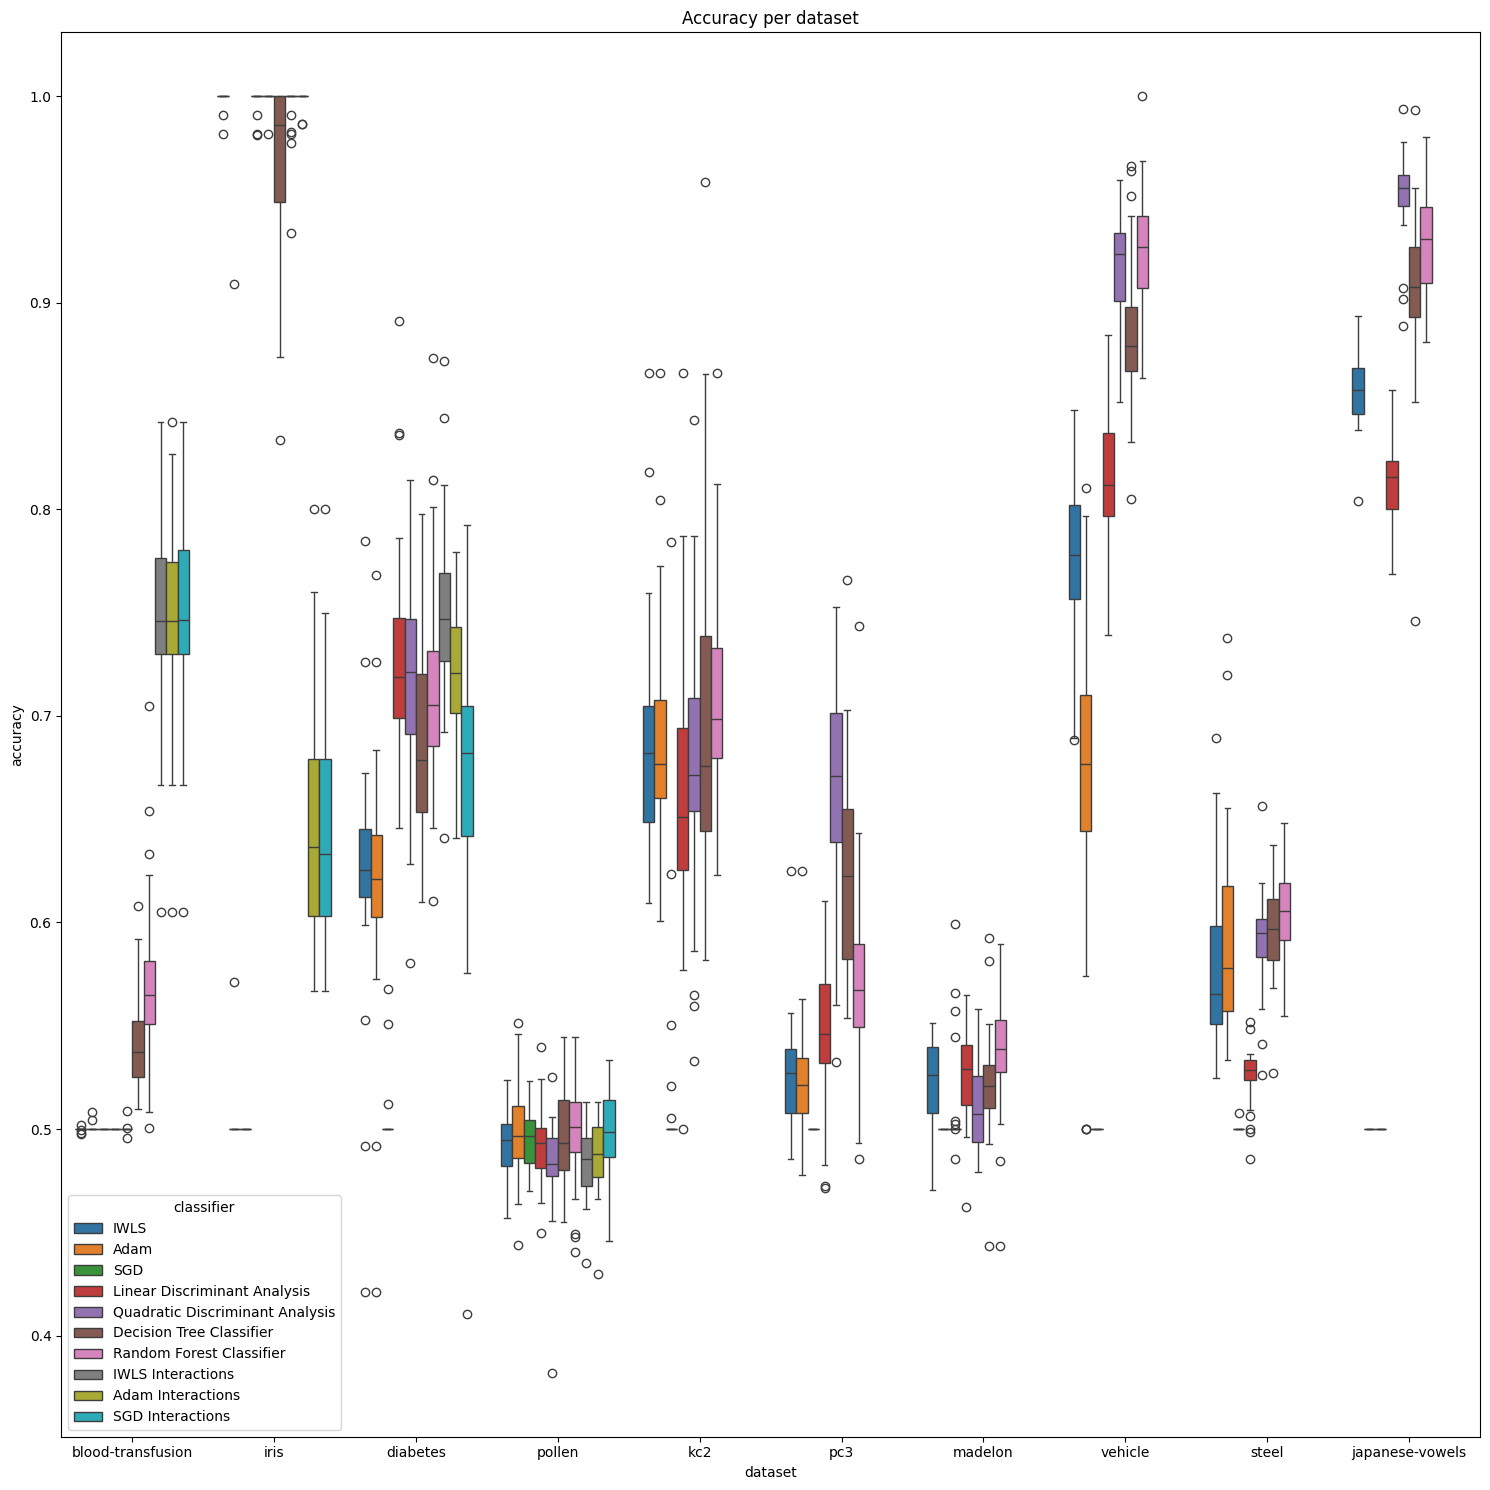

In [10]:
accuraciesDf = pd.DataFrame(accuracies[0],columns=['accuracy','classifier','seed','split','interactions','dataset'])
accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
concatAcc=accuraciesDf
for i in range(1,len(accuracies)):
    accuraciesDf = pd.DataFrame(accuracies[i],columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
    concatAcc=pd.concat([concatAcc, accuraciesDf], ignore_index=True, sort=False)
plt.figure(figsize=(15,15))
sns.boxplot(concatAcc,x='dataset',y='accuracy',hue='classifier')
plt.title('Accuracy per dataset')
plt.tight_layout()
plt.savefig('Accuracy-per-dataset.pdf')
plt.show()

# Accuracies per classifier

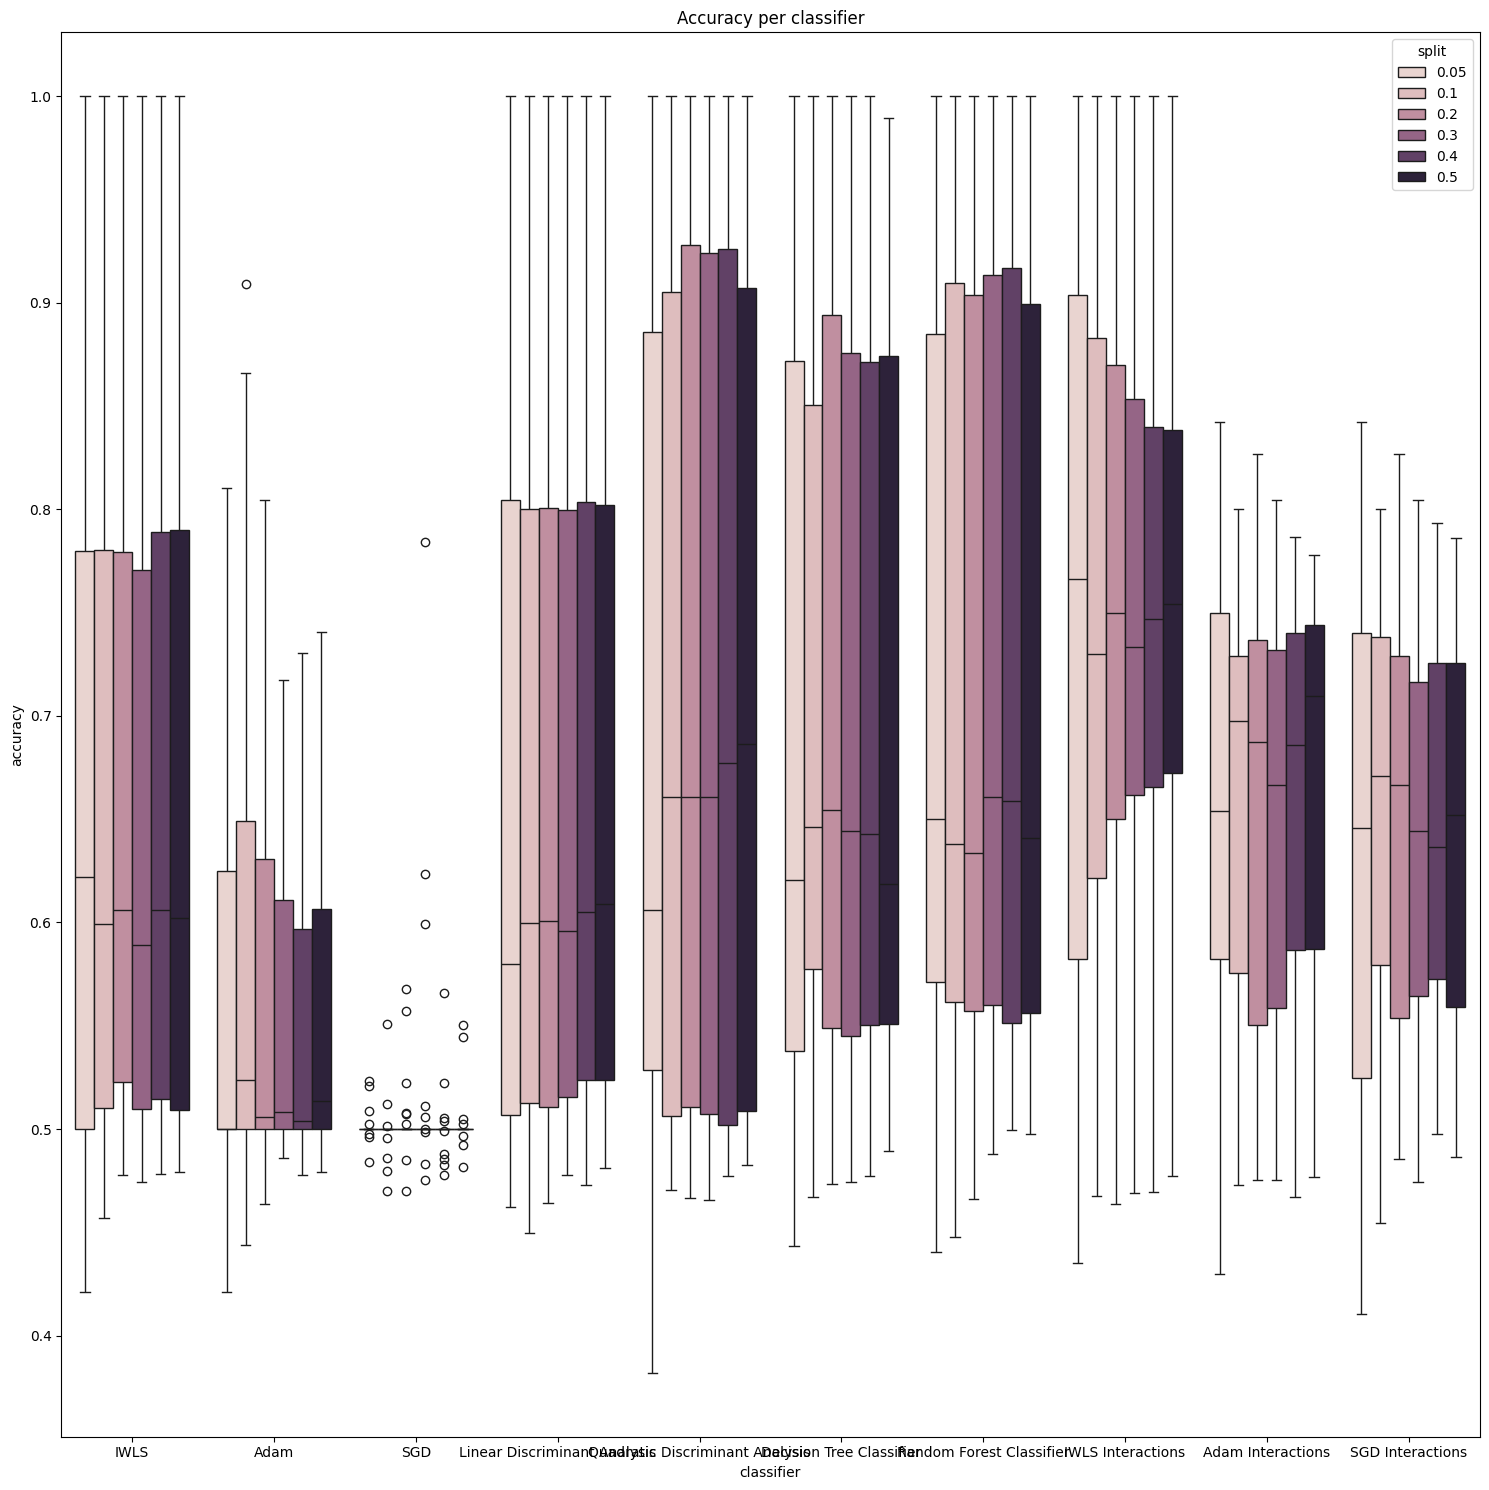

In [11]:
accuraciesDf = pd.DataFrame(accuracies[0],columns=['accuracy','classifier','seed','split','interactions','dataset'])
accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
concatAcc=accuraciesDf
for i in range(1,len(accuracies)):
    accuraciesDf = pd.DataFrame(accuracies[i],columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
    concatAcc=pd.concat([concatAcc, accuraciesDf], ignore_index=True, sort=False)
plt.figure(figsize=(15,15))
sns.boxplot(concatAcc,x='classifier',y='accuracy',hue='split')
plt.title('Accuracy per classifier')
plt.tight_layout()
plt.savefig('Accuracy-per-classifier.pdf')
plt.show()

## Accuracies per split

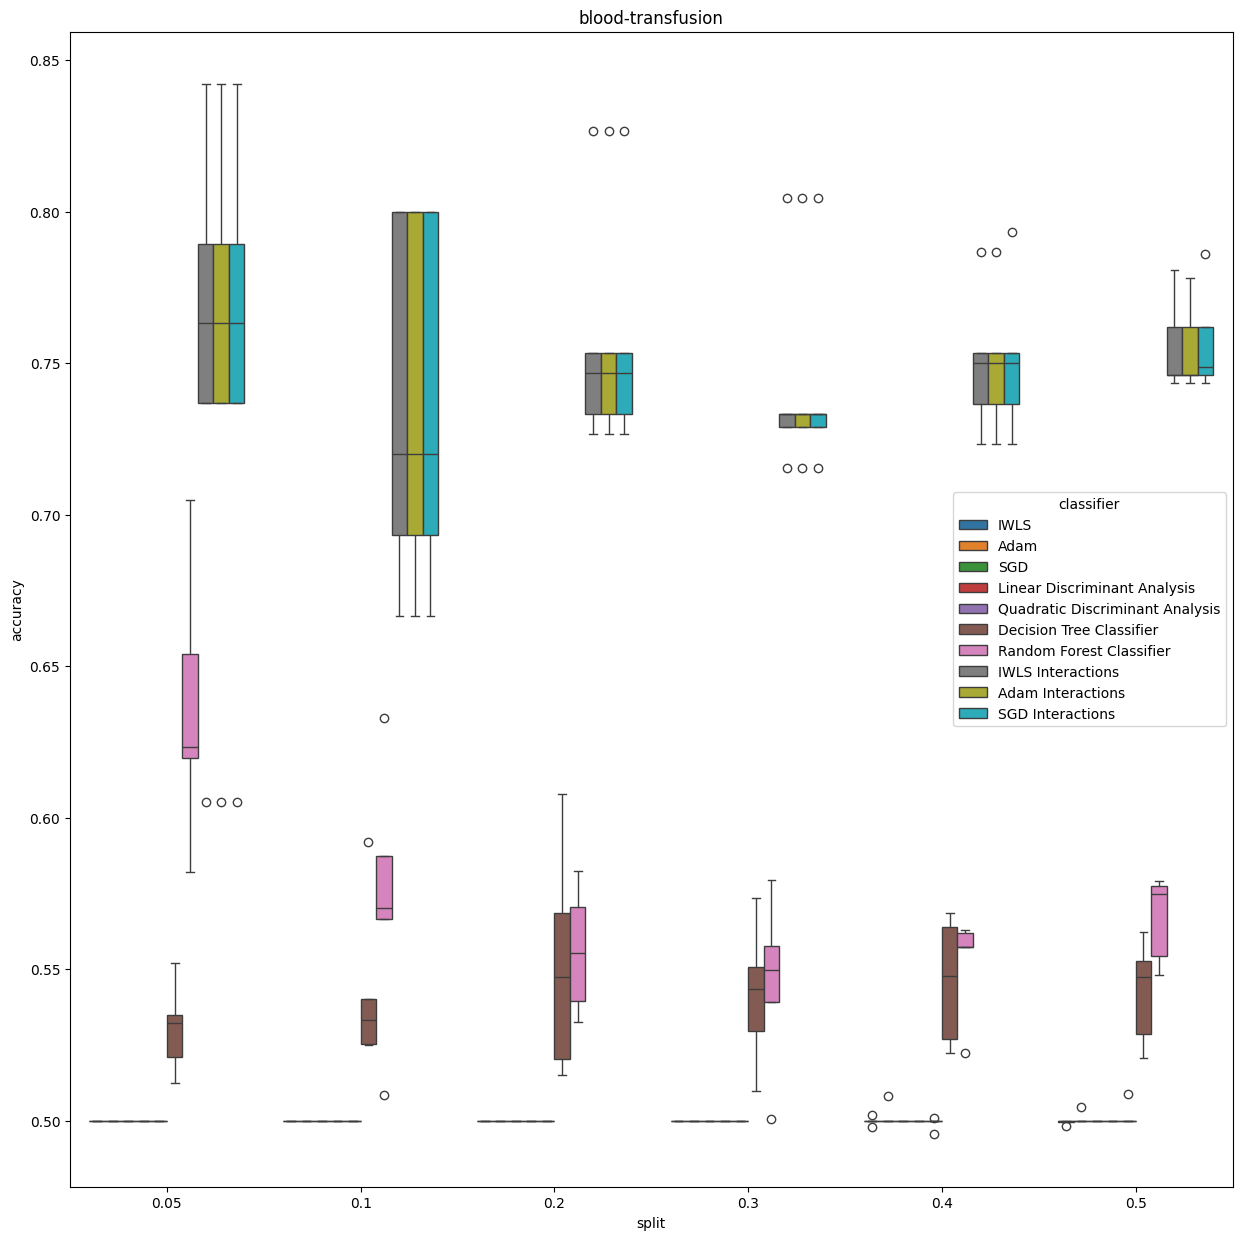

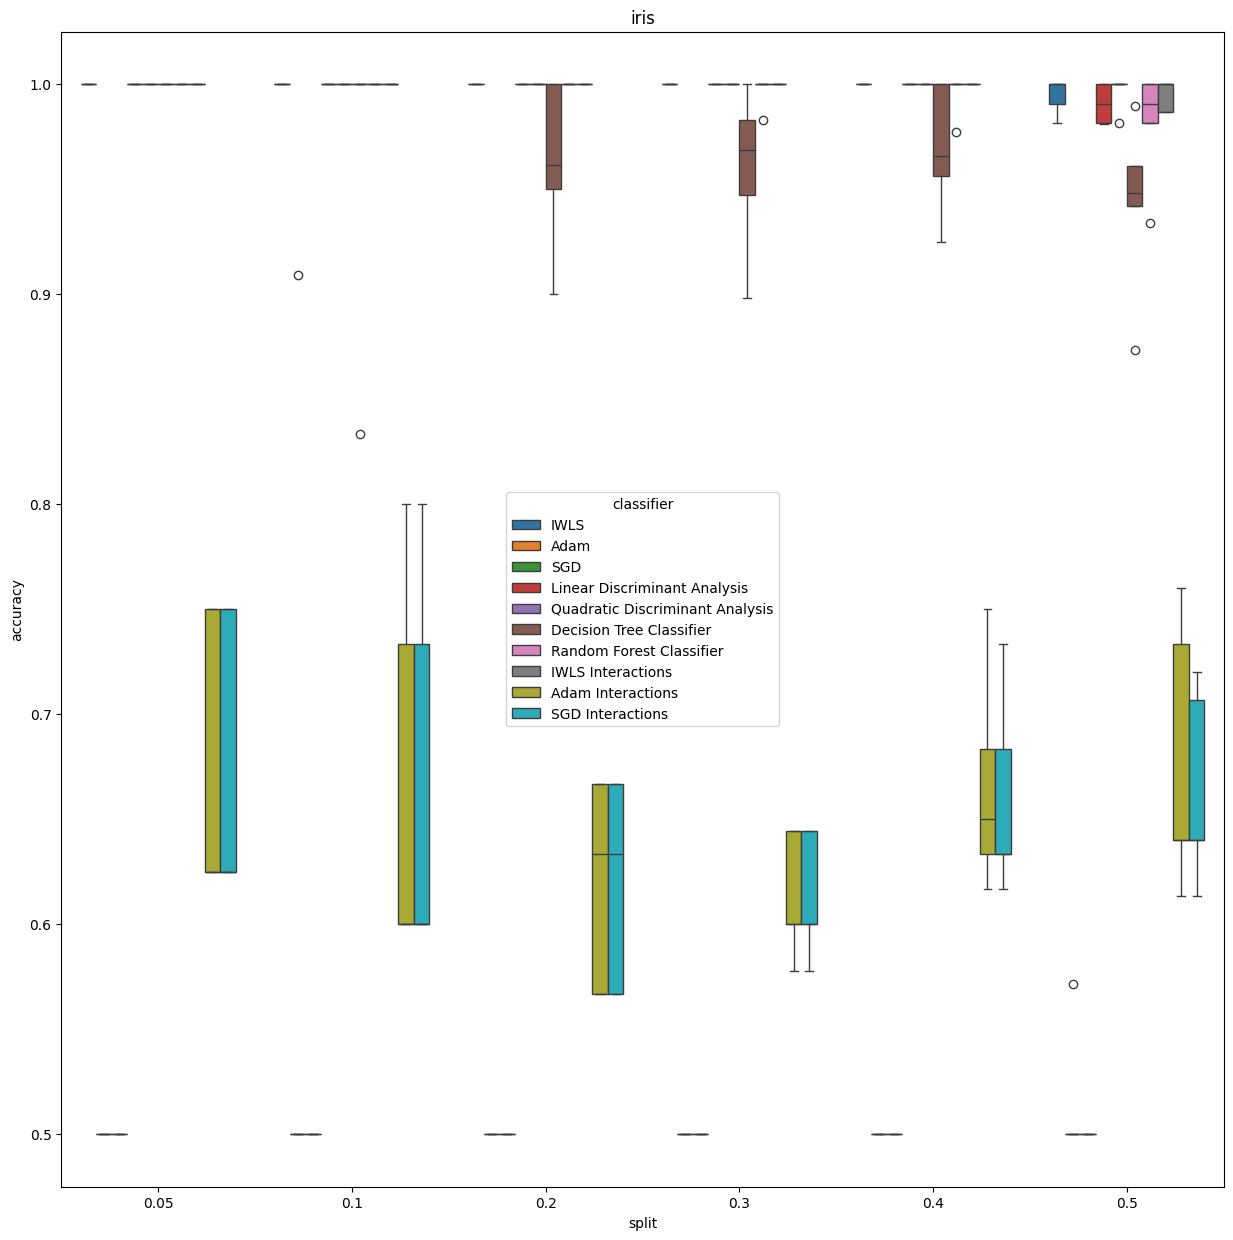

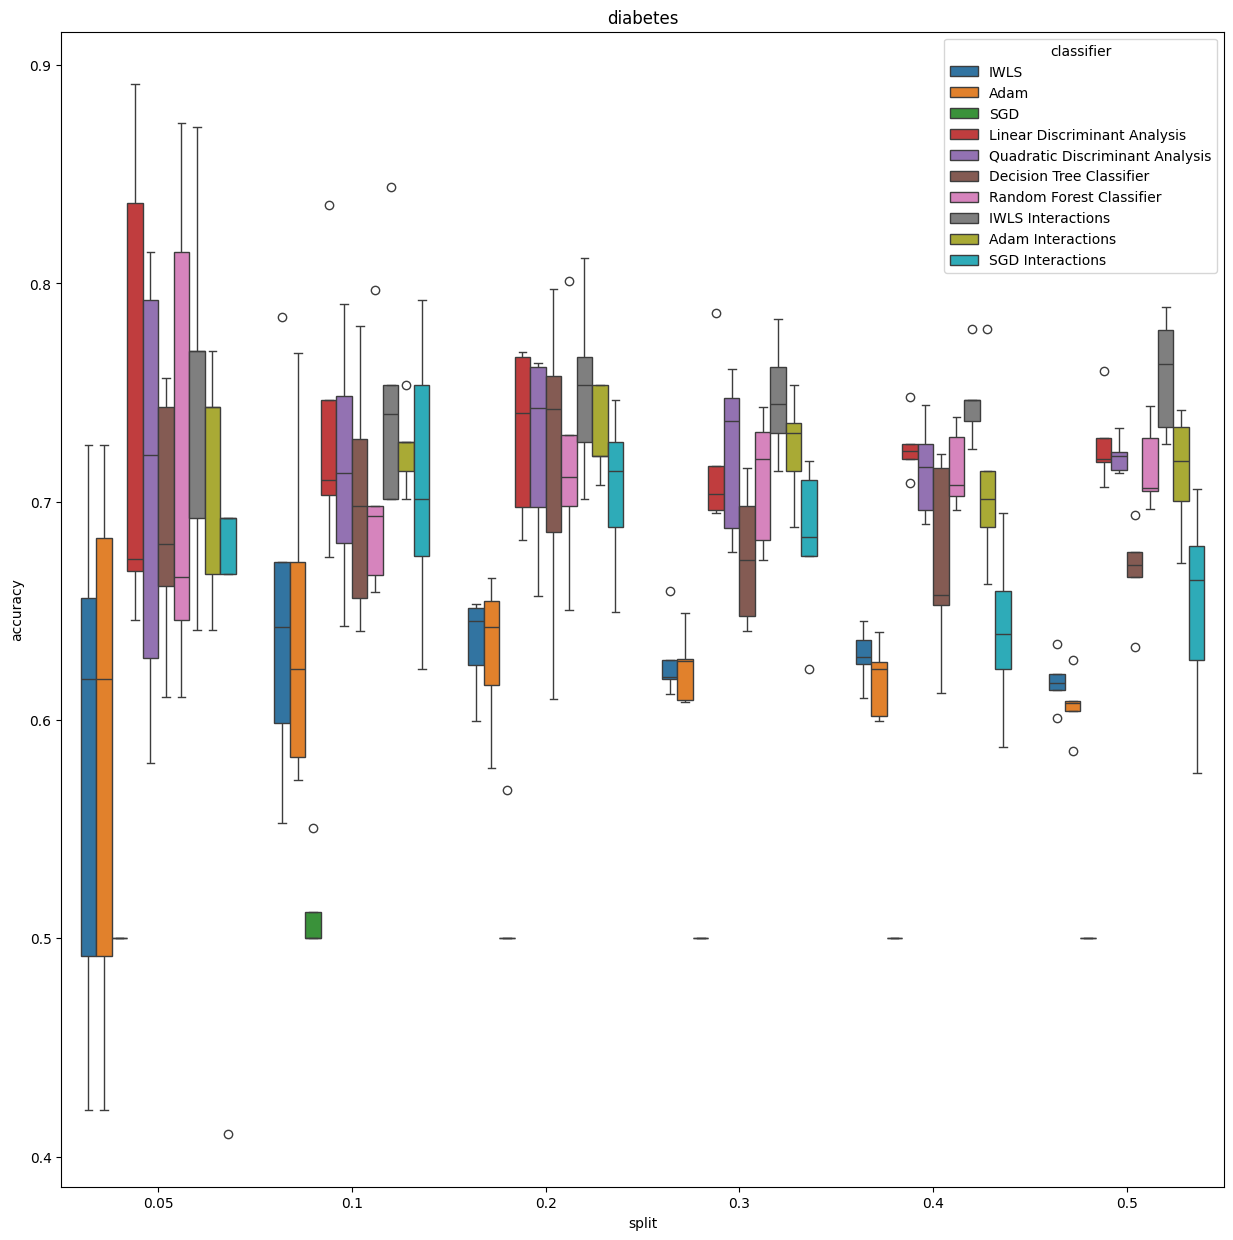

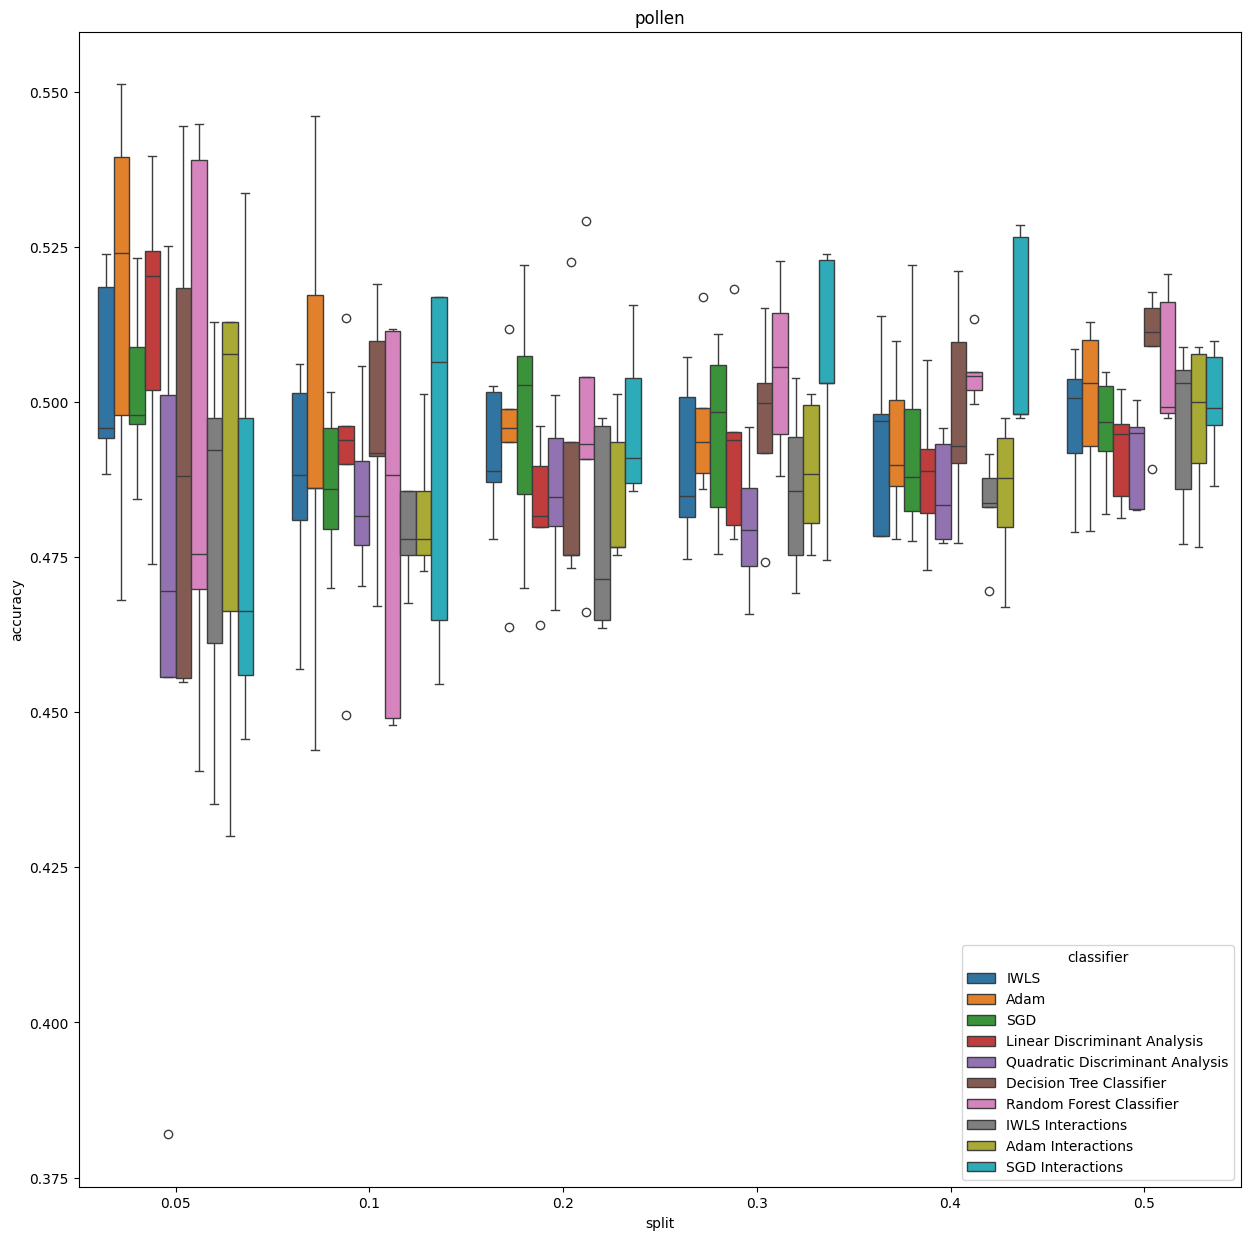

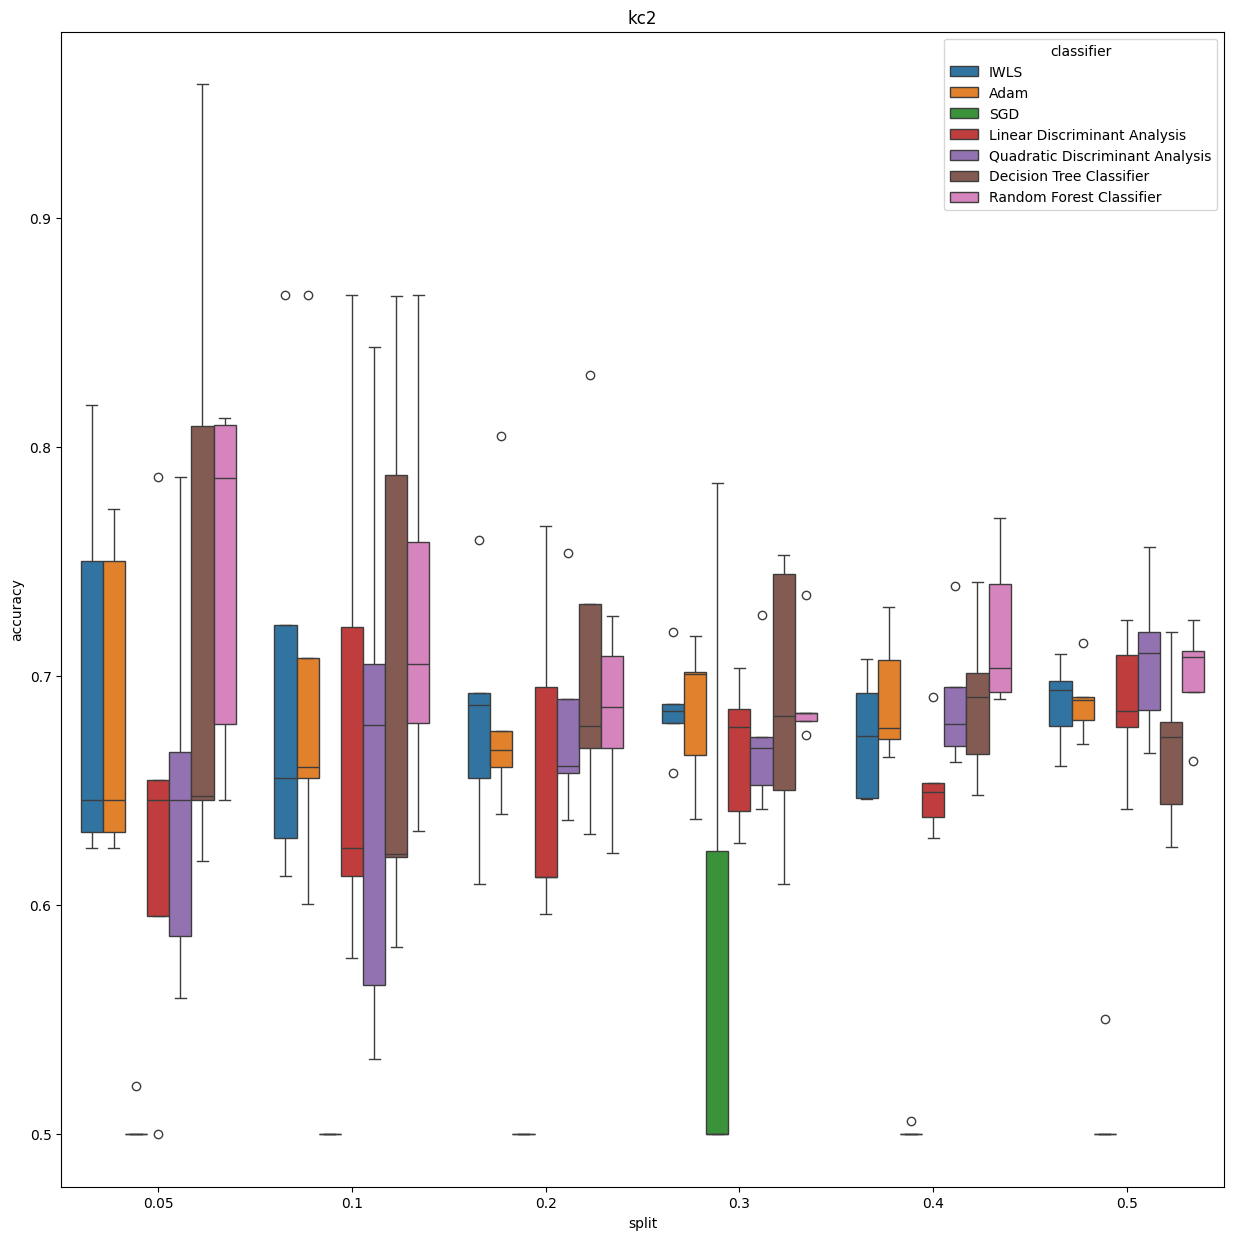

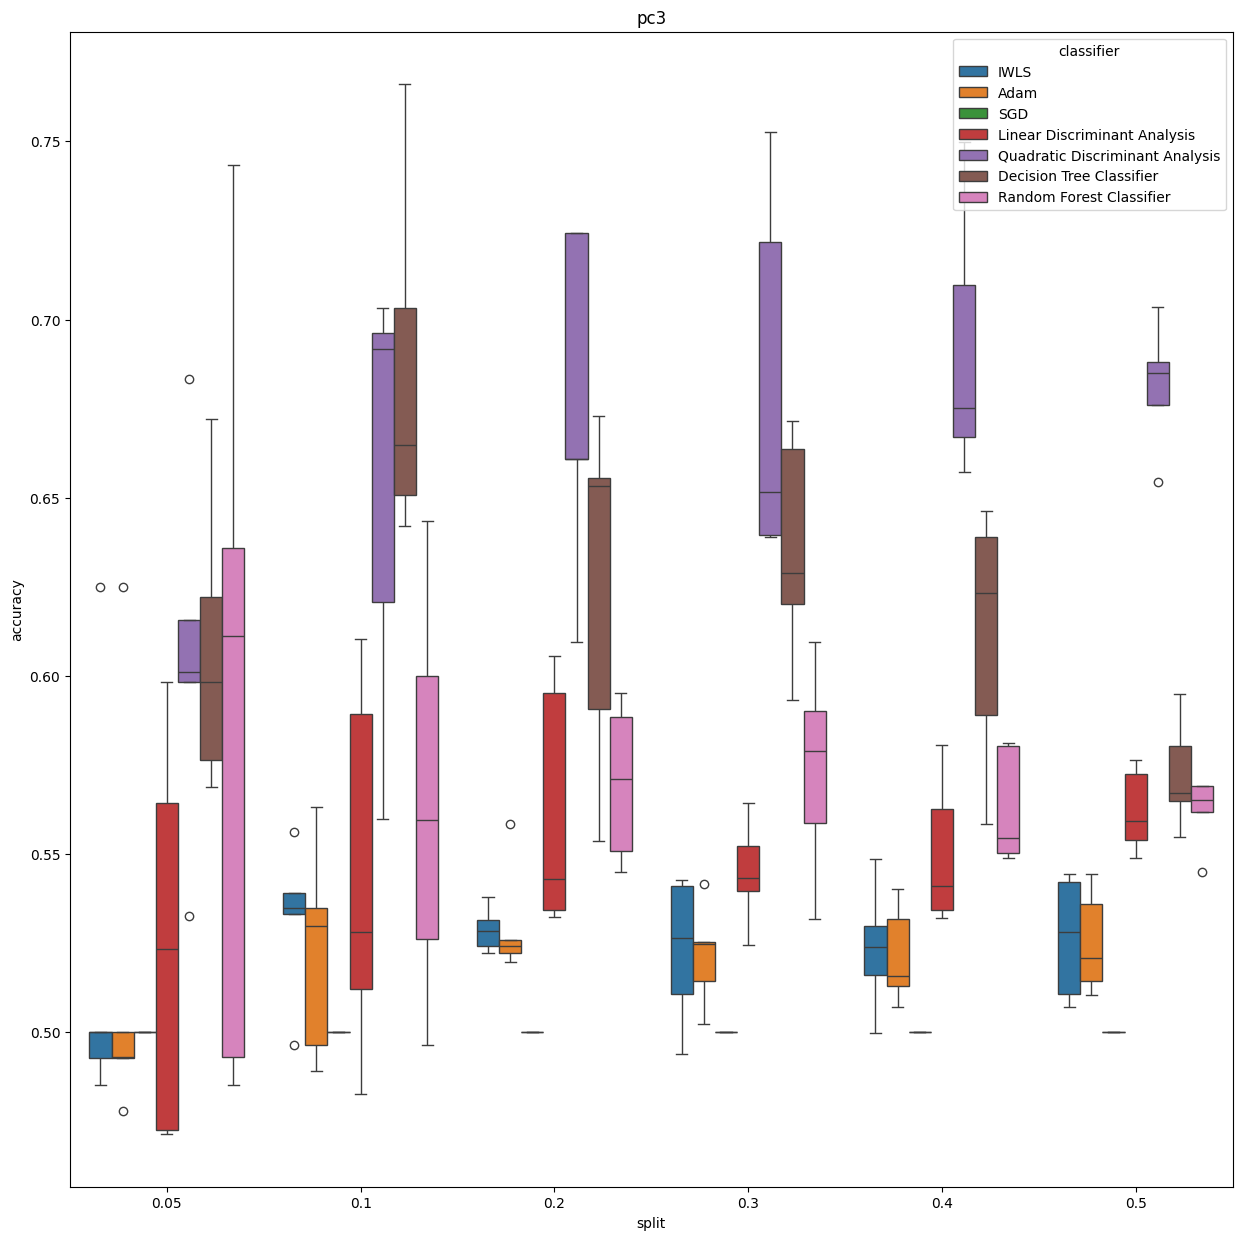

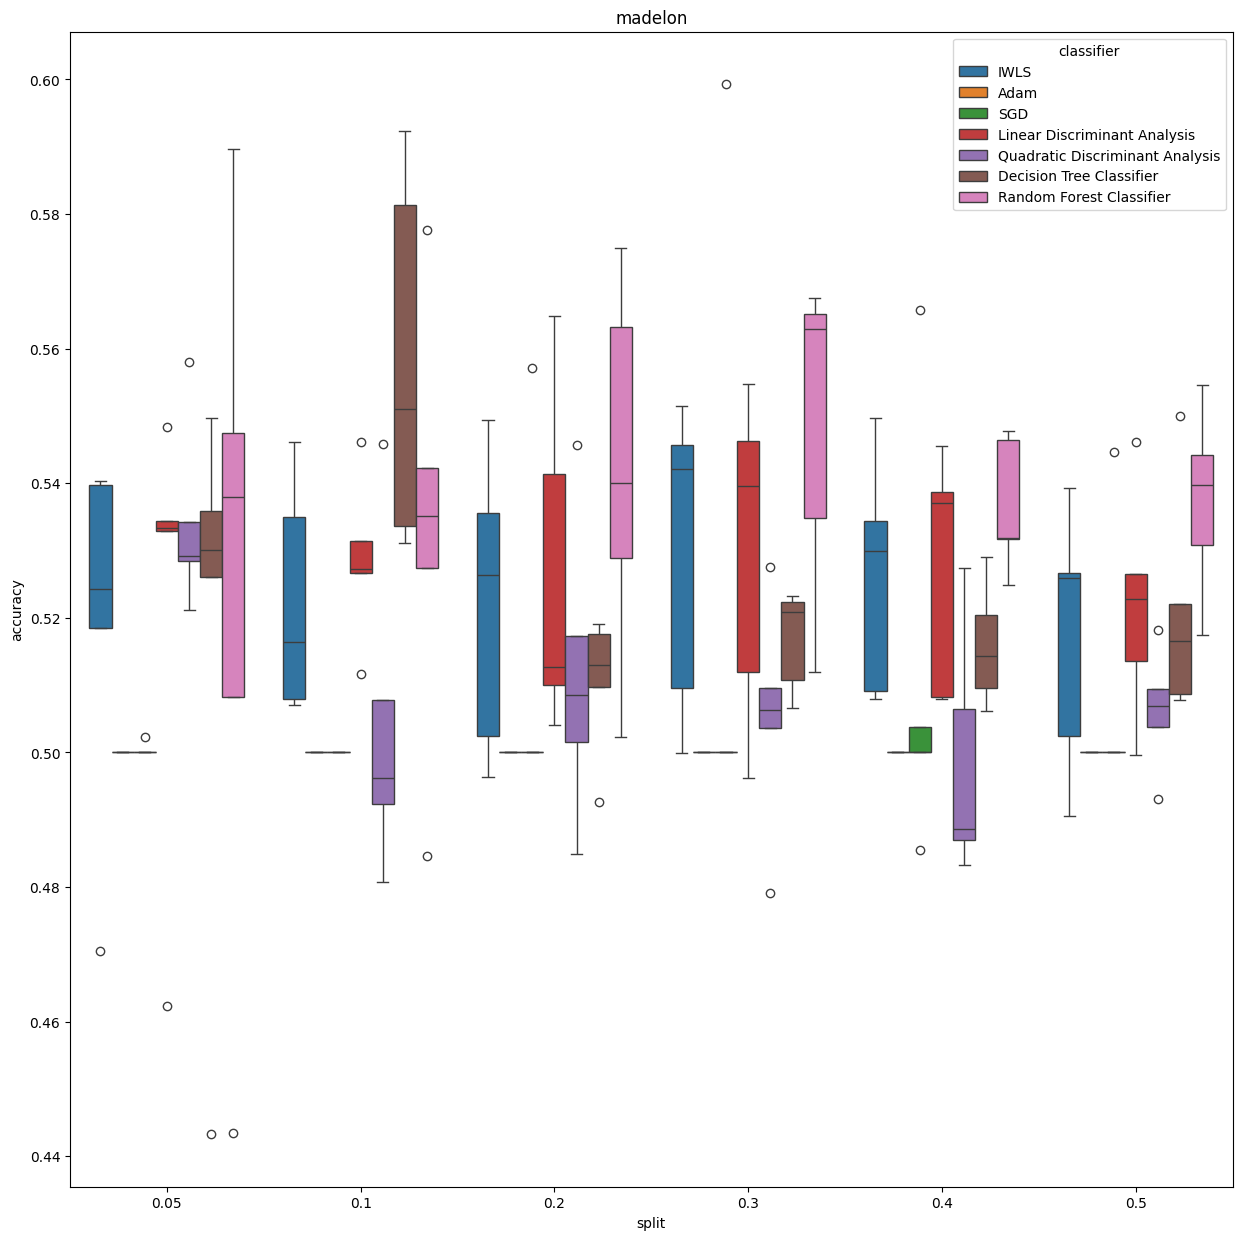

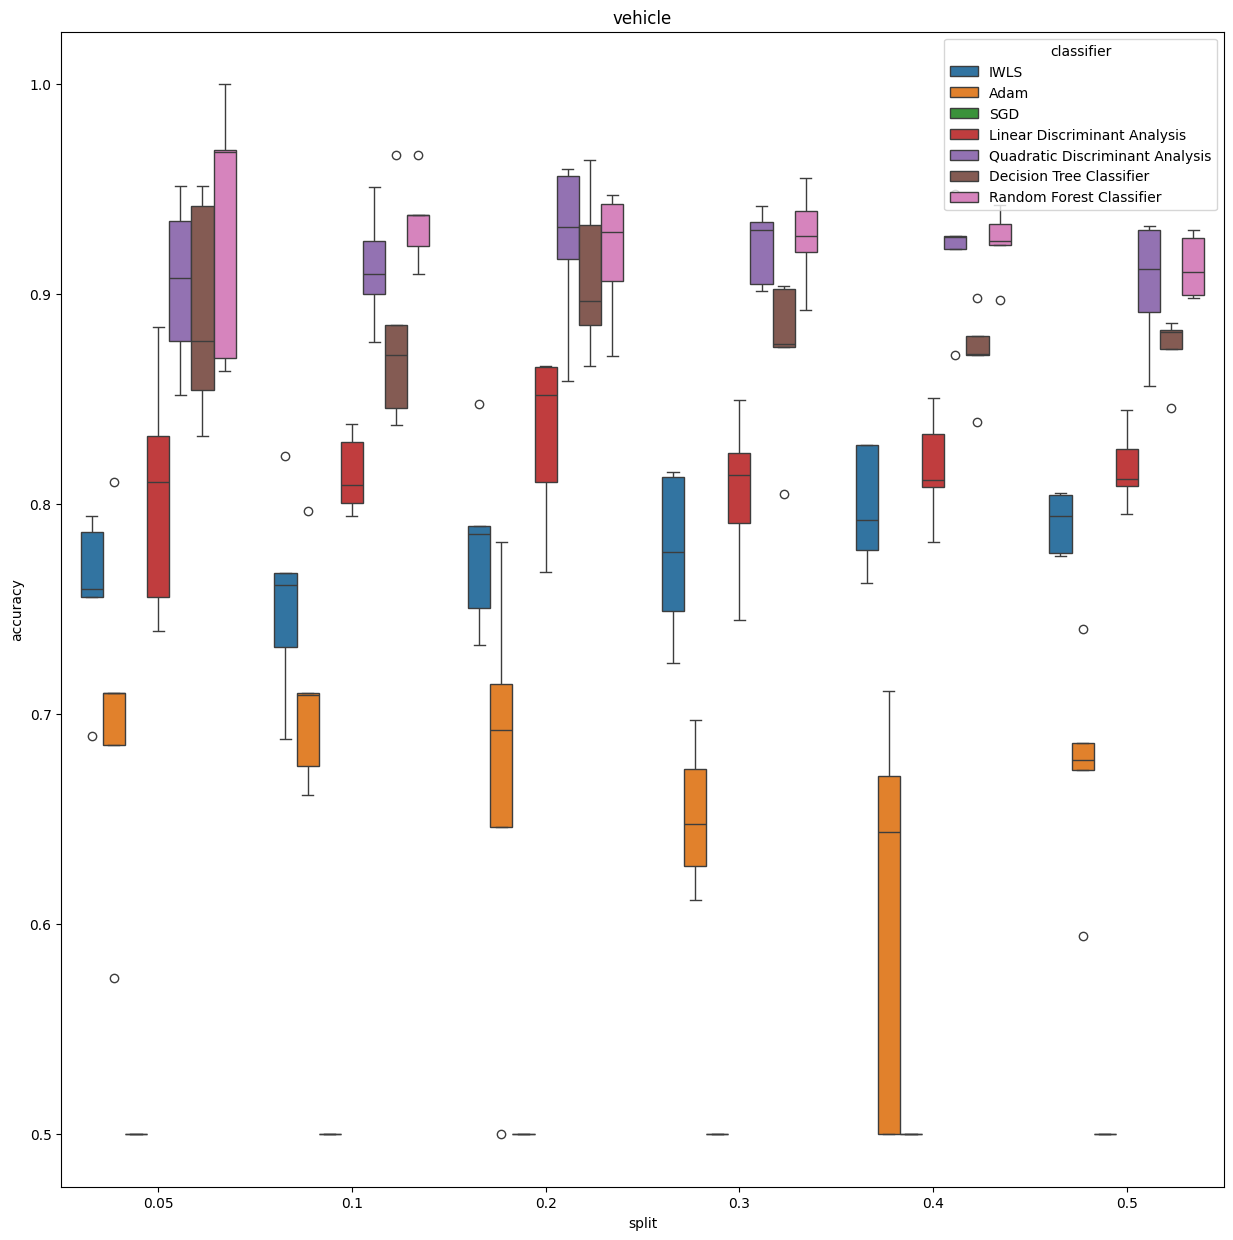

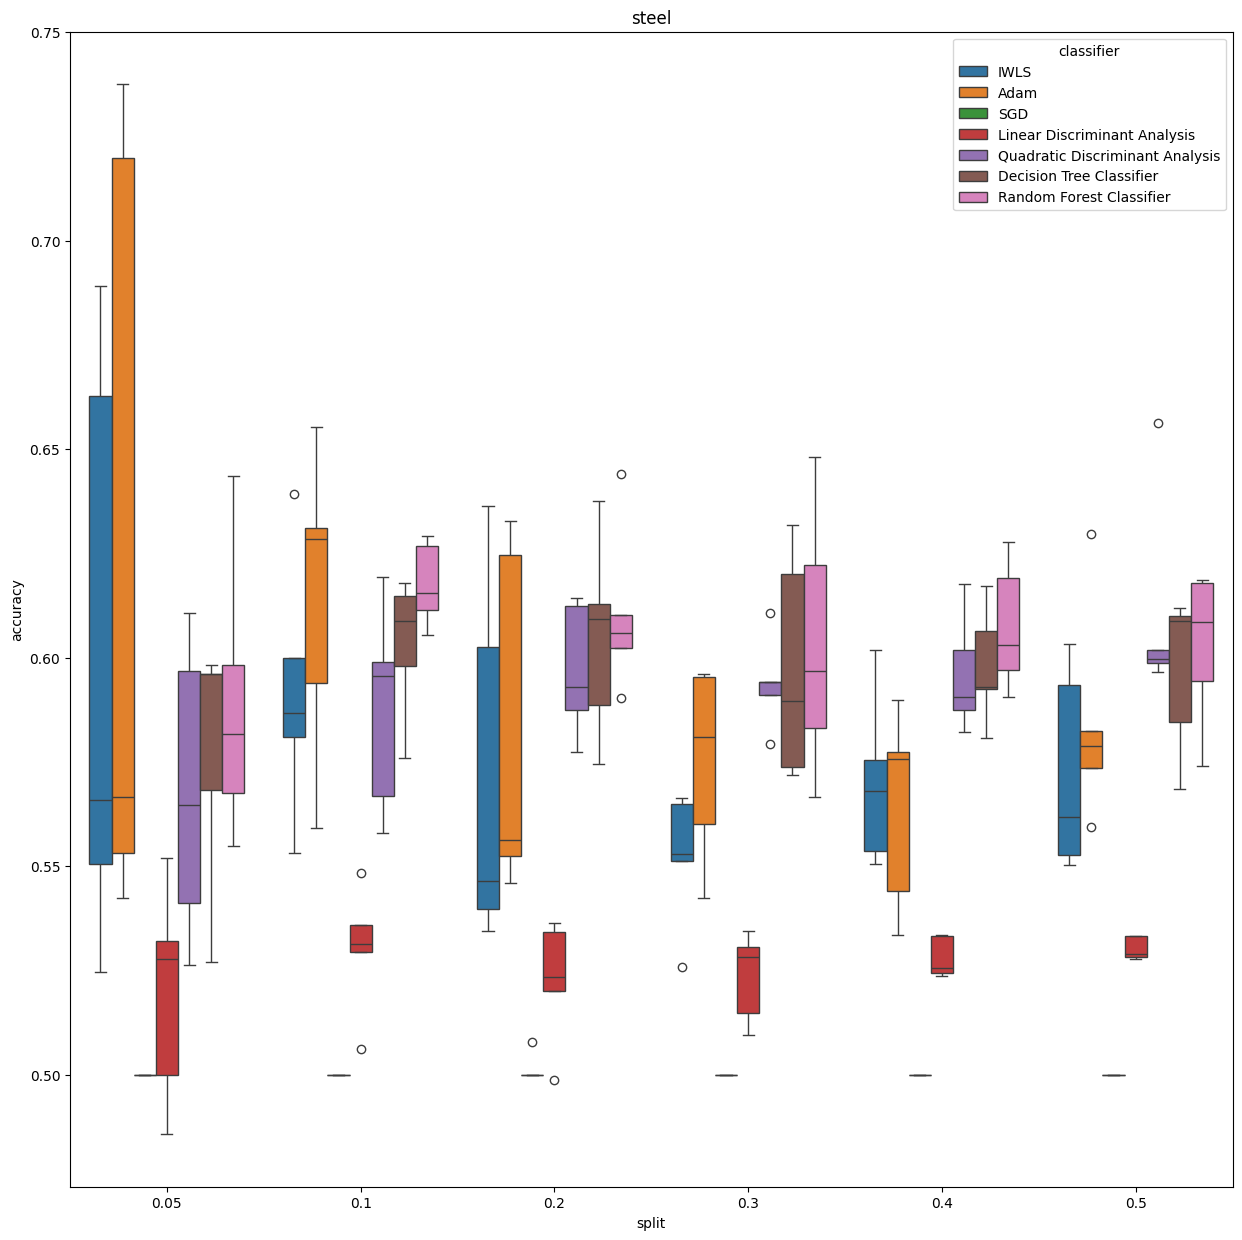

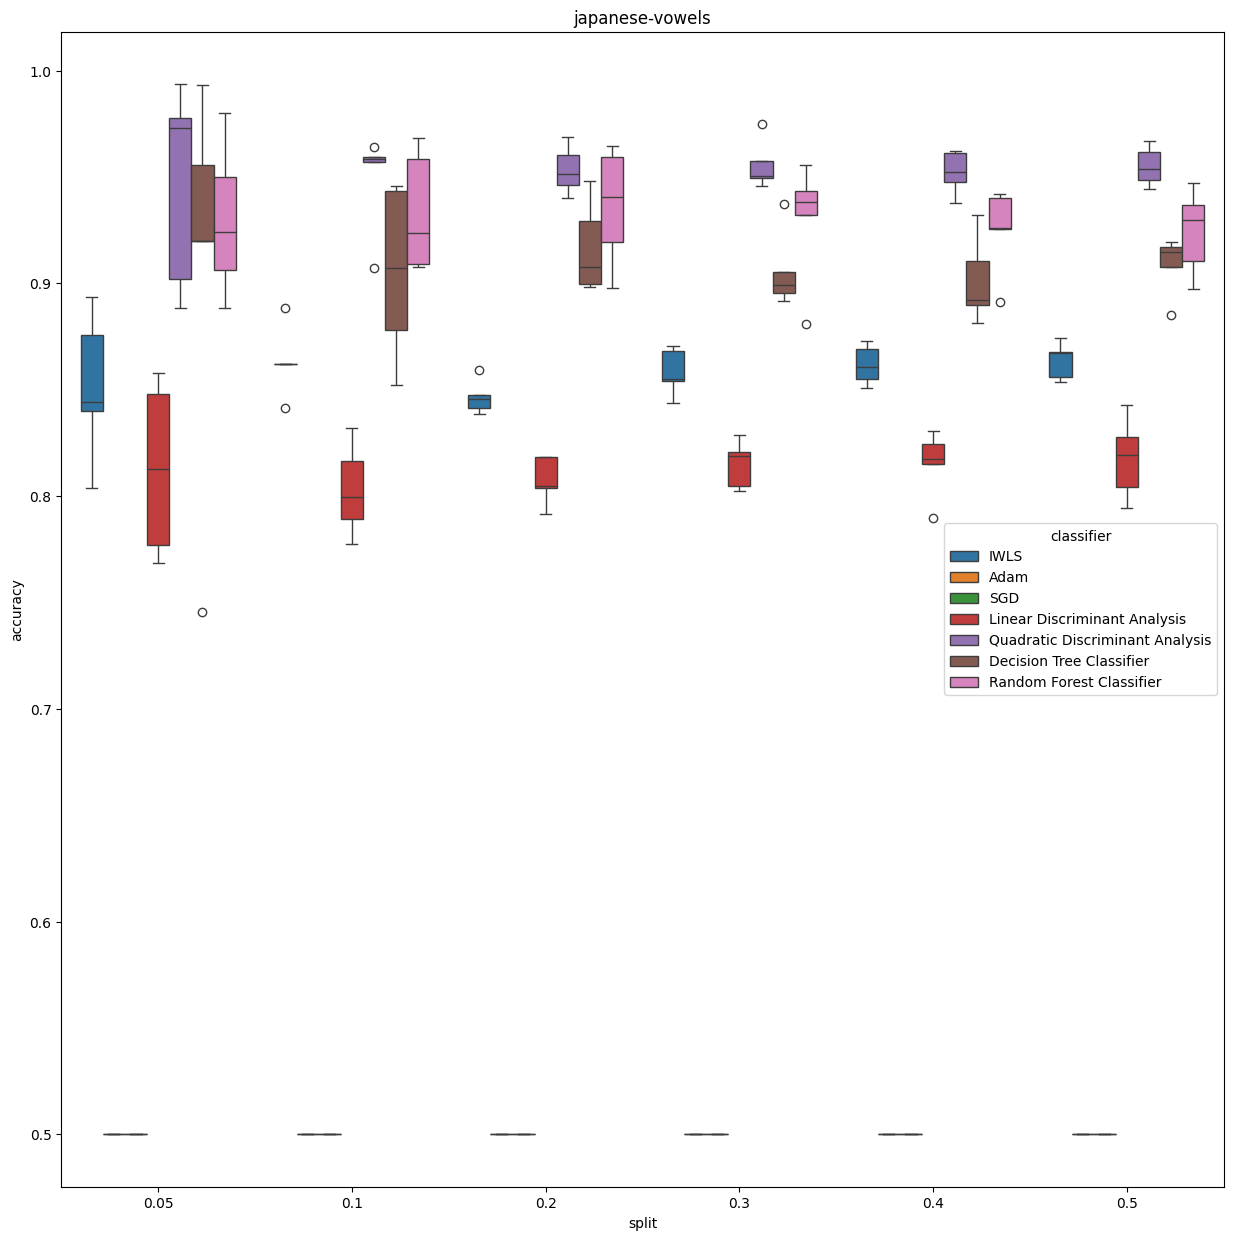

In [12]:
for accuracy in accuracies:
    accuraciesDf = pd.DataFrame(accuracy,columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)

    
    plt.figure(figsize=(15,15))
    plt.title(accuraciesDf['dataset'][0])
    sns.boxplot(accuraciesDf,x='split',y='accuracy',hue='classifier')
    plt.savefig(str(accuraciesDf['dataset'][0])+'.pdf')
    plt.show()

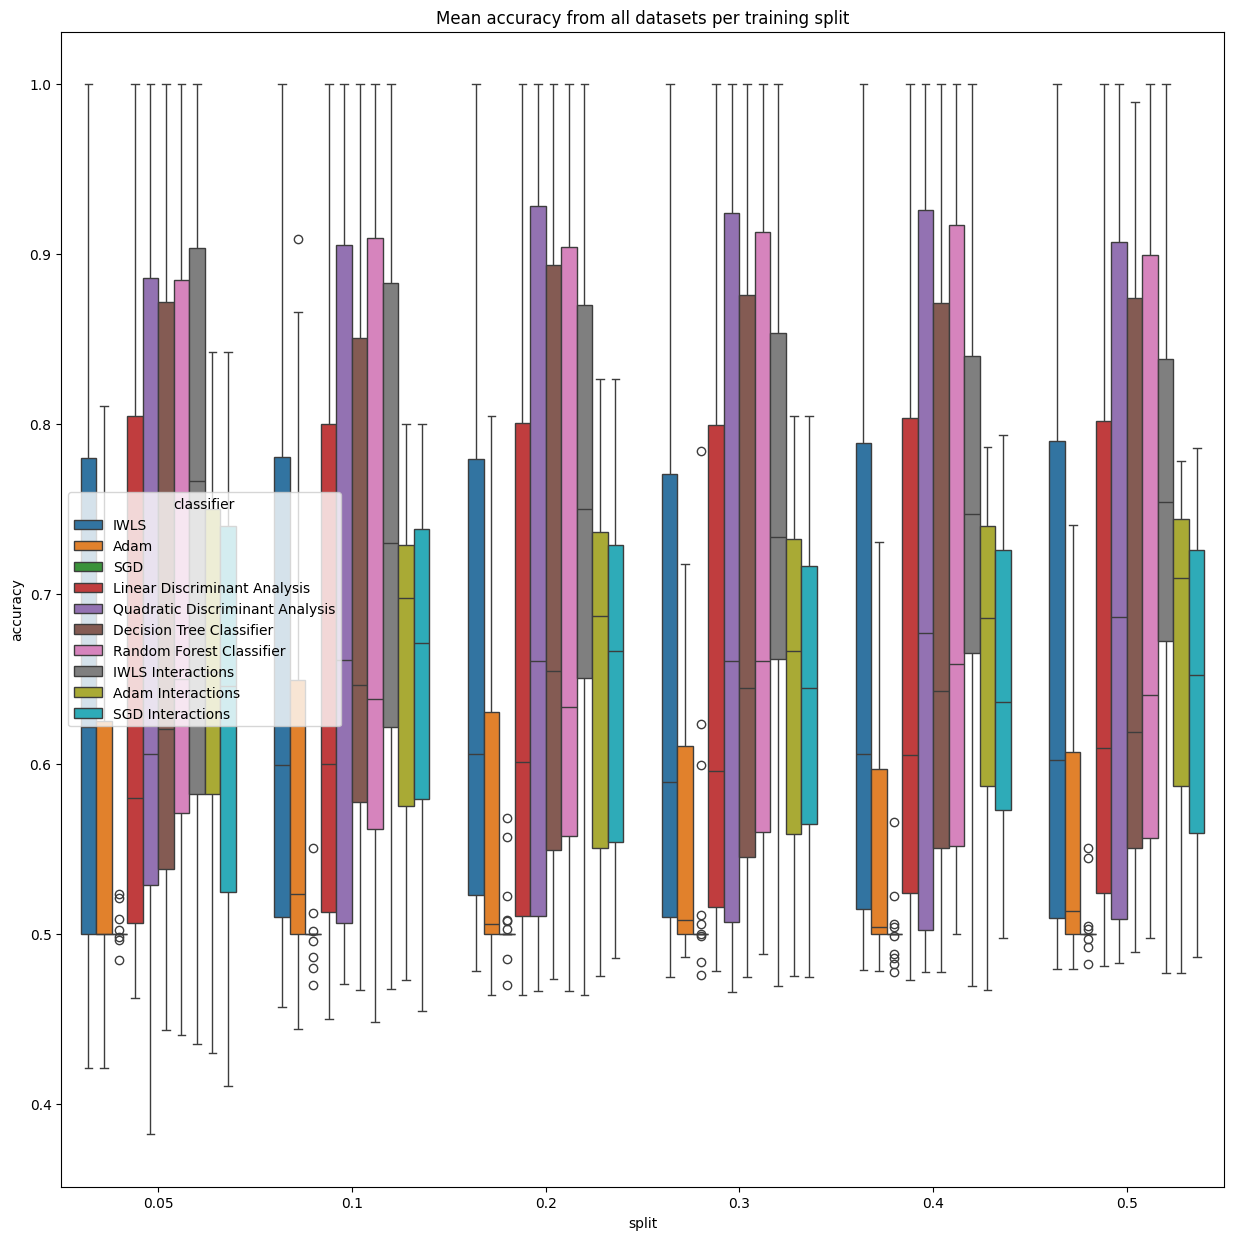

In [13]:

accuraciesDf = pd.DataFrame(accuracies[0],columns=['accuracy','classifier','seed','split','interactions','dataset'])
accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)

# meanacc = getMeanAccuracyPerSplit(accuraciesDf)
concatAcc = accuraciesDf
for i in range(1,len(accuracies)):
    accuraciesDf = pd.DataFrame(accuracies[i],columns=['accuracy','classifier','seed','split','interactions','dataset'])
    accuraciesDf=accuraciesDf.apply(lambda x:mapOptimizerToString(x),axis=1)
    # meanacc = getMeanAccuracy(accuraciesDf)
    concatAcc=pd.concat([concatAcc, accuraciesDf], ignore_index=True, sort=False)


plt.figure(figsize=(15,15))
plt.title('Mean accuracy from all datasets per training split')
sns.boxplot(concatAcc,x='split',y='accuracy',hue='classifier')
plt.savefig('Mean-accuracy-from-all-datasets-per-training-split.pdf')
plt.show()

# Loss function

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_21568\2650784700.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  costsDf=pd.concat([costsDf, costDf], ignore_index=True, sort=False)


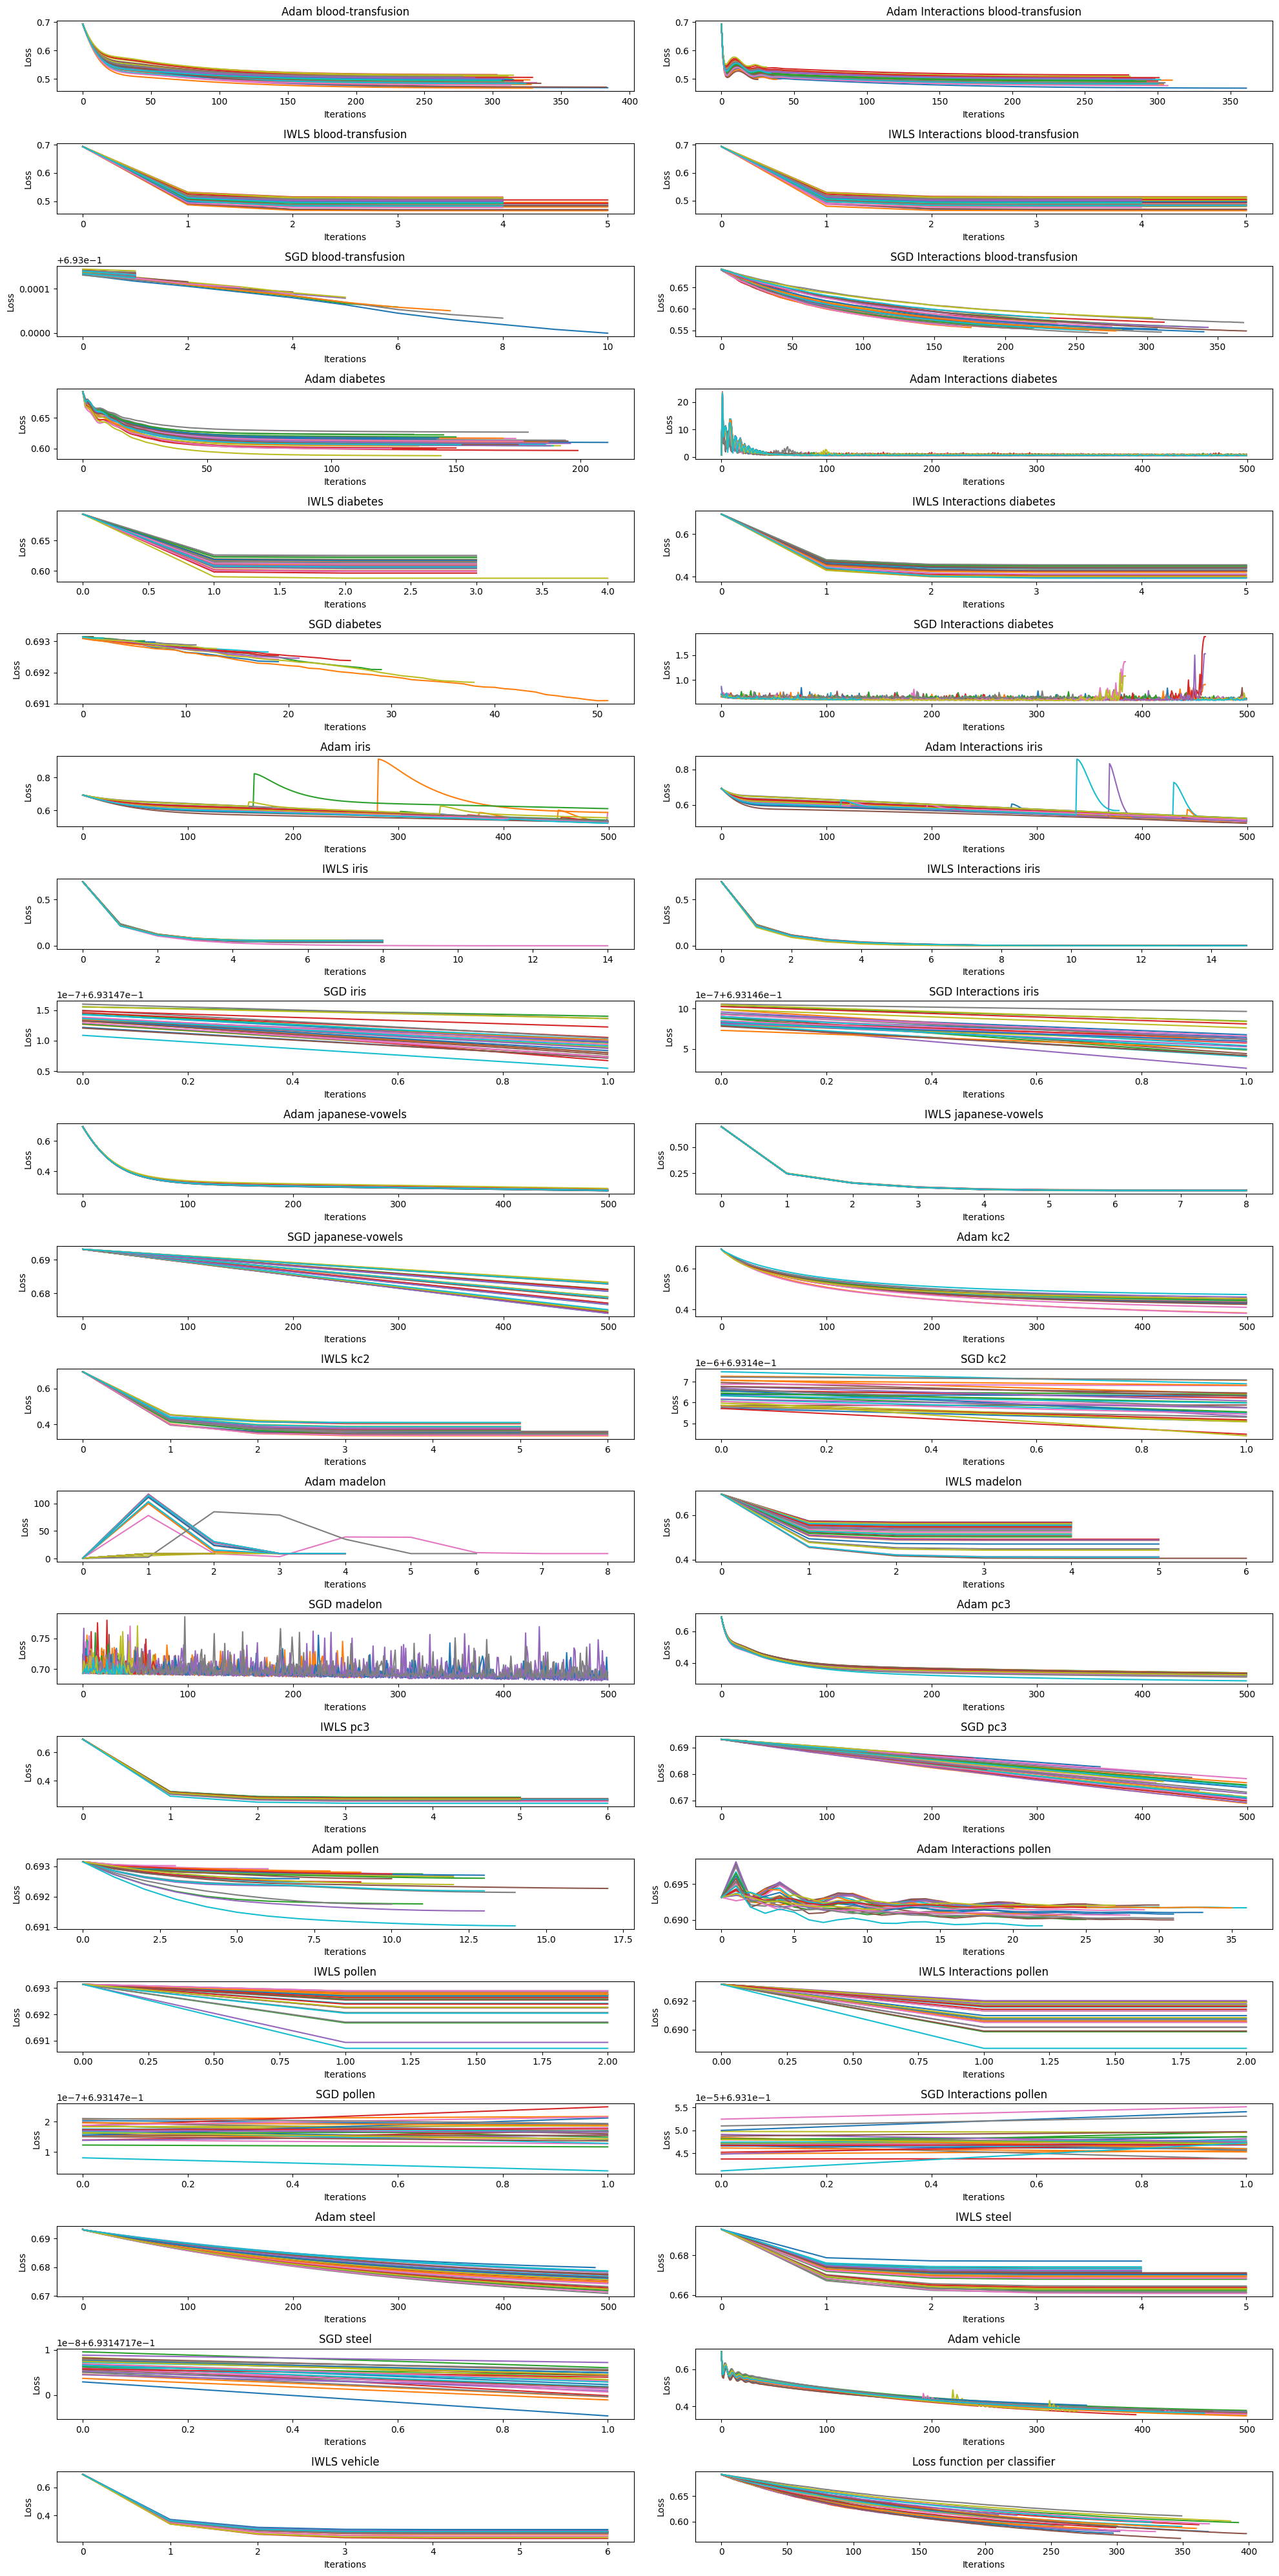

In [14]:
# TODO: Optionally, we could calculate the horizontal mean (commented means variable) but grouped by split
costsDf = pd.DataFrame(columns=['cost','classifier','seed','split','interactions','dataset'])
for cost in costs:
    costDf = pd.DataFrame(columns = ['cost','classifier','seed','split','interactions','dataset'],data=cost)
    costsDf=pd.concat([costsDf, costDf], ignore_index=True, sort=False)
costsDf=costsDf.apply(lambda x:mapOptimizerToString(x),axis=1)
grouped =costsDf.groupby(by=['dataset','classifier'])

costFunctionToPlot = []
for name, group in grouped:
    # means = group['cost'].values.mean(axis=0)
    costFunctionToPlot.append([group['cost'],group['classifier'].iloc[0],group['dataset'].iloc[0]])

i =0 
totalNumberOfGraphs = len(costFunctionToPlot)
numberOfColumns = 2
numberOfRows = totalNumberOfGraphs // numberOfColumns 
if totalNumberOfGraphs % numberOfColumns != 0:
    numberOfRows += 1

positionsVector = range(1,totalNumberOfGraphs + 1)
fig = plt.figure(1,figsize=(20,40))
#fig.tight_layout()
for algorithmCosts in costFunctionToPlot:
    ax = fig.add_subplot(numberOfRows,numberOfColumns,positionsVector[i])
    ax.title.set_text(algorithmCosts[1]+" "+ algorithmCosts[2])
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    for costsToPlot in algorithmCosts[0]:
        sns.lineplot(costsToPlot, ax=ax)
    i+=1
plt.title('Loss function per classifier')
plt.tight_layout()
plt.savefig('Loss-function-per-classifier.pdf')
plt.show()

# Convergance per dataset and classifier

C:\Users\prusak.patryk\AppData\Local\Temp\ipykernel_21568\3132699996.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  costsDf=pd.concat([costsDf, costDf], ignore_index=True, sort=False)


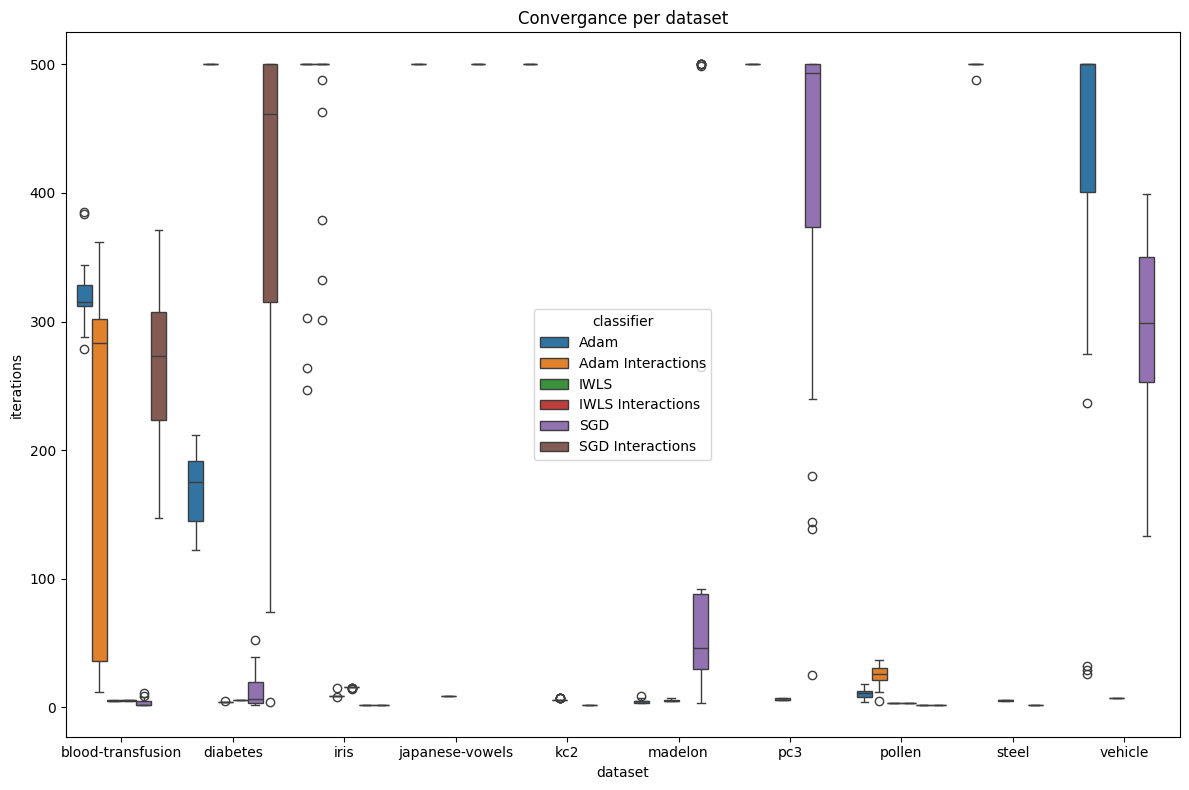

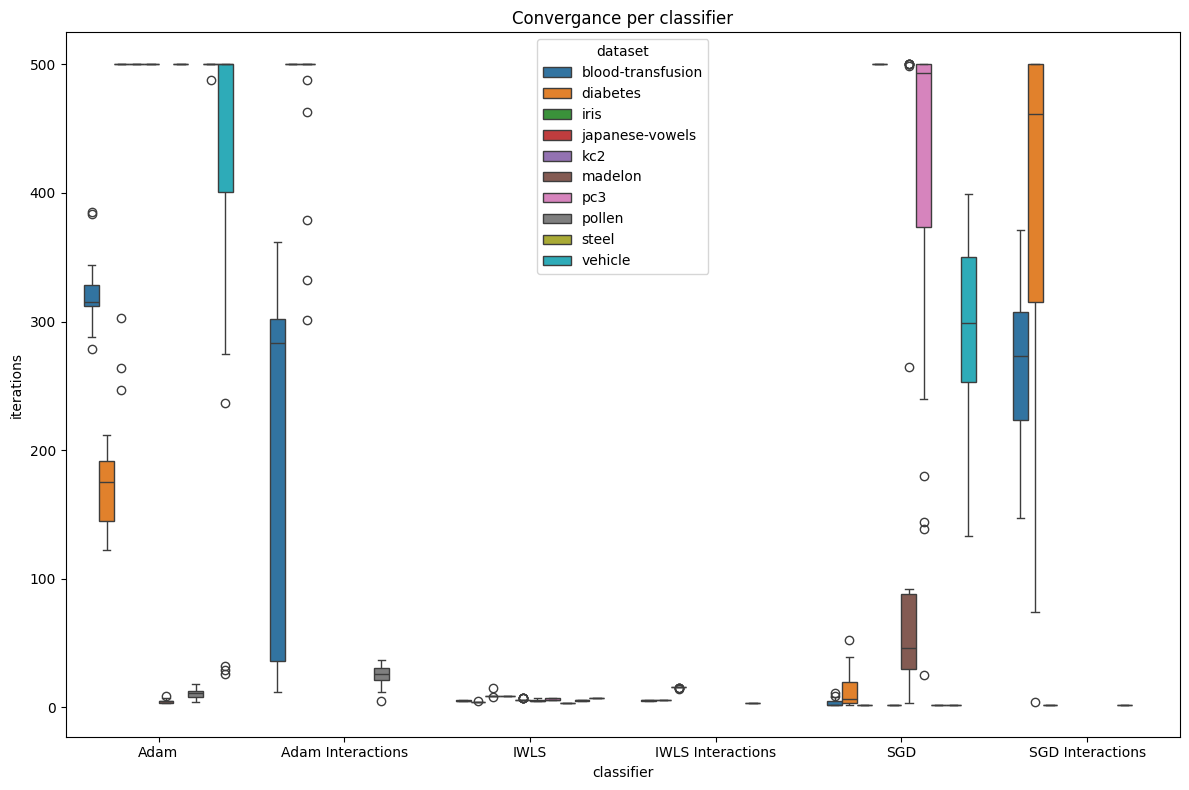

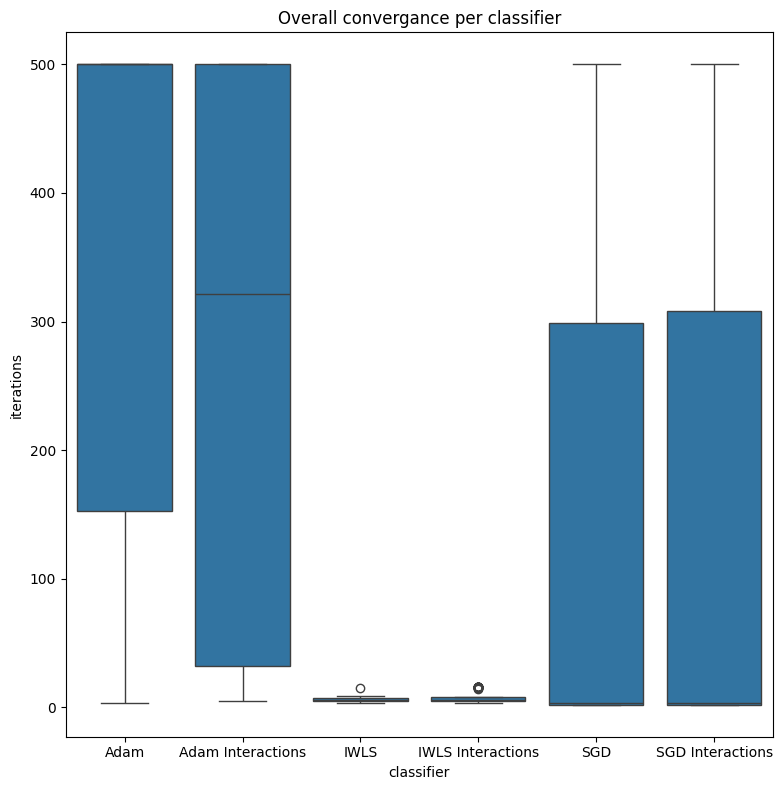

In [15]:
costsDf = pd.DataFrame(columns=['cost','classifier','seed','split','interactions','dataset'])
for cost in costs:
    costDf = pd.DataFrame(columns = ['cost','classifier','seed','split','interactions','dataset'],data=cost)
    costsDf=pd.concat([costsDf, costDf], ignore_index=True, sort=False)
costsDf=costsDf.apply(lambda x:mapOptimizerToString(x),axis=1)
grouped =costsDf.groupby(by=['dataset','classifier'])

costFunctionToPlot = []
for name, group in grouped:
    # means = group['cost'].values.mean(axis=0)

    
    for row_index, row in group.iterrows():
        costFunctionToPlot.append([len(row['cost']),group['classifier'].iloc[0],group['dataset'].iloc[0]])

costFunctionToPlotDf = pd.DataFrame(costFunctionToPlot,columns=['iterations','classifier','dataset'])
plt.figure(figsize=(12,8))
plt.title('Convergance per dataset')
sns.boxplot(data=costFunctionToPlotDf,x='dataset',y='iterations',hue='classifier')
plt.tight_layout()
plt.savefig('Convergance-per-dataset.pdf')
plt.show()

plt.figure(figsize=(12,8))
plt.title('Convergance per classifier')
sns.boxplot(data=costFunctionToPlotDf,x='classifier',y='iterations',hue='dataset')
plt.tight_layout()
plt.savefig('Convergance-per-classifier.pdf')
plt.show()

plt.figure(figsize=(8,8))
plt.title('Overall convergance per classifier')
sns.boxplot(data=costFunctionToPlotDf,x='classifier',y='iterations')
plt.tight_layout()
plt.savefig('Overall-convergance-per-classifier.pdf')
plt.show()